# Cyberbully Detection

# Note:
1. Twitter Cyberbully dataset download fails with the Failed tweet fetching error via Tweepy.api.
2. Mendeley dataset doesn't have clear labels in the dataset.
3. Using the kaggle dataset: https://www.kaggle.com/c/detecting-insults-in-social-commentary/data?select=train.csv

The classes are binary. Insult or not represented with boolean values. The cleaned dataset is being used after applying stemming from NLTK as data cleaning step was not quoted in the task.

[Google Drive Link](https://drive.google.com/drive/folders/1V2hDRIbtZQnHpSjcWjbVeebdevDyOa-G?usp=sharing)

# Brief about process involved in cleaning the dataset.

Stemming and Lemmatization.

1. Stemming refers to a process that clips the ends of the words.

For ex: 

Hoping, Hope, Hop to the stem Hop
Port, Porter, Portray to the stem Port

It is often done using Porter Algorithm. NLTK has this module in it.

2. Lemmatization often refers to the process of returning to the base or dictionary form of a word often known as lemma.

For ex:

to jump, jumped, jumps, jumping to the base form jump.

It is often done using WordNetLemmatizer.

* Stemmer is often faster to implement as it operates without context on a single word.



In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Conv1D, Input, Embedding, MaxPooling1D, Dense, GlobalMaxPooling1D, SpatialDropout1D, Dropout, Flatten,LSTM
from keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow-text
import tensorflow_text as text


     |████████████████████████████████| 4.9 MB 3.8 MB/s 
     |████████████████████████████████| 462 kB 37.9 MB/s 


In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_path = "/content/drive/MyDrive/IIT_PAT_Assesment/clean_dataset.csv"

In [ ]:
df = pd.read_csv(train_path)
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_size = 0.8
train_end = int(len(df)*train_size)
train_df = df[:train_end].reset_index(drop=True)
test_df = df[train_end:].reset_index(drop=True)

In [ ]:
y_train = train_df.pop('Insult')
y_test = test_df.pop('Insult')

In [ ]:
X_train = train_df
X_test = test_df

In [ ]:
#X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
X_train

,Comment
0,oh dear now you will be sorry in fact you will...
1,you are blind deaf and dumb now go back to bed
2,hey rynthih who the hell r u speaking on sachi...
3,now why would you come up here talking about y...
4,new jersey where you save money on gas and hav...
...,...
5259,you are disgusting absolutely disgusting there...
5260,petrsmailbox boom
5261,yes it was a re enactment of the big bang theory
5262,sure the people who actually diagnose and trea...


In [ ]:
X_test

,Comment
0,no doubt the kid is a major douchenozzle but i...
1,shearnut that you may be correct i do not like...
2,you and your sarcasm
3,i just laugh at some of you trolls saying weav...
4,sarko s dream was not realized yet total had t...
...,...
1311,pussy bitch take my fuking house off of your p...
1312,i already explained that sissy but i ll say it...
1313,lol as if capcom listens watch them fuck this ...
1314,i defended lana every time someone said bad th...


In [ ]:
#label encoding the target variable
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [ ]:
y_train

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
X_train.shape

(5264, 1)

In [ ]:
X_train = X_train.to_numpy().ravel()
X_test = X_test.to_numpy().ravel()

# Embedding Extraction Stage.

1. Tf-Idf stage.

(Concept revisited via https://www.youtube.com/watch?v=SbdESKmJC8M)

In [ ]:
#applying tf-idf at word level which represents tf-idf scores of every term in different documents.
tfidf_feat = TfidfVectorizer(analyzer='word', max_features=5000, use_idf=True)#token_pattern=r'\w{1,}')
tfidf_feat.fit(train_df['Comment'])
tf_len = len(tfidf_feat.vocabulary_)
print("Length of vocabulary is", tf_len)
print("Length of training samples", X_train.shape)
X_train_tfidf = tfidf_feat.transform(X_train).toarray().astype('float64')
X_test_tfidf = tfidf_feat.transform(X_test).toarray().astype('float64')


#X_train_tfidf = tf.sparse.reorder(X_train_tfidf)
#X_test_tfidf = tf.sparse.reorder(X_test_tfidf)
#X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1],1)
#X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1],1)


Length of vocabulary is 5000
Length of training samples (5264,)


In [ ]:
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print("n_samples: %d, n_features: %d" % X_test_tfidf.shape)

n_samples: 5264, n_features: 5000
n_samples: 1316, n_features: 5000


In [ ]:
print("Shape of Y_train",y_train.shape)
print("Shape of Y_test" , y_test.shape)

Shape of Y_train (5264,)
Shape of Y_test (1316,)


T-f matrix is a sparse matrix where each row is a document in our training corpus and each column corresponds to a term/words in the bow list.

2. Fast-Text embedding extraction stage.


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2022-04-19 20:44:14--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.96.23, 13.33.96.115, 13.33.96.64, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.96.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  28.9MB/s    in 24s     

2022-04-19 20:44:39 (27.2 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!ls

drive  sample_data  wiki-news-300d-1M.vec.zip


In [ ]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
!ls

drive  sample_data  wiki-news-300d-1M.vec  wiki-news-300d-1M.vec.zip


In [ ]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(train_df['Comment'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(16874, 300)

In [ ]:
print("Shape of training sequence is ", train_seq_x.shape)
print("Shape of testing sequence is ", test_seq_x.shape)

Shape of training sequence is  (5264, 70)
Shape of testing sequence is  (1316, 70)


 
3. Bag of Words embedding extraction stage : Creating DTM (Document Term matrix) via Count Vectorizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english',ngram_range=(2,2), max_features=5000)
tf_len = 5000
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray().astype('float64')
X_test_bow = bow_vectorizer.fit_transform(X_test).toarray().astype('float64')

In [ ]:
print("n_samples: %d, n_features: %d" % X_train_bow.shape)
print("n_samples: %d, n_features: %d" % X_test_bow.shape)

n_samples: 5264, n_features: 5000
n_samples: 1316, n_features: 5000


In [ ]:
print("Shape of Y_train",y_train.shape)
print("Shape of Y_test" , y_test.shape)

Shape of Y_train (5264,)
Shape of Y_test (1316,)


## Summary of Embedding Extraction Stage.

1. X_train_tfidf, Y_train, X_test_tfidf, Y_test represent the train,test split obtained via tf-idf embeddings.

2. X_train_bow, Y_train, X_test_bow, Y_test represent the train, test split obtained via bow embeddings.

3. embedding_matrix being the embedding for the fast-text model.

# Model Training Stage.

Training the following models on the embeddings obtained above.

1. CNN-1D.
2. LSTM.
3. CNN-LSTM.


* A. Training CNN-1D Models on the extracted Embeddings.


In [ ]:
# Training CNN-1D classifier on TF-IDF Features.
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1])

input = Input(batch_shape=(None, tf_len, 1))
drop20 = SpatialDropout1D(0.3)(input)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(drop20)
drop21 = Dropout(0.5)(conv2)
conv22 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop21)
drop22 = Dropout(0.5)(conv22)
pool2 = MaxPooling1D(pool_size=2)(drop22)
flat2 = Flatten()(pool2)
out = Dense(1, activation='sigmoid')(flat2)
model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 spatial_dropout1d (SpatialD  (None, 5000, 1)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         768       
                                                                 
 dropout (Dropout)           (None, 4996, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4992, 64)          41024     
                                                                 
 dropout_1 (Dropout)         (None, 4992, 64)          0         
                                                             

In [ ]:
history = model.fit(x= X_train_tfidf,y=y_train,validation_data=(X_test_tfidf,y_test),shuffle=True,epochs=10,workers=2,use_multiprocessing=True)

Epoch 1/10
165/165 [==============================] - 19s 112ms/step - loss: 0.3295 - accuracy: 0.8596 - val_loss: 0.4240 - val_accuracy: 0.8078
Epoch 2/10
165/165 [==============================] - 18s 107ms/step - loss: 0.3092 - accuracy: 0.8672 - val_loss: 0.4332 - val_accuracy: 0.8138
Epoch 3/10
165/165 [==============================] - 18s 107ms/step - loss: 0.2940 - accuracy: 0.8763 - val_loss: 0.4525 - val_accuracy: 0.8100
Epoch 4/10
165/165 [==============================] - 18s 108ms/step - loss: 0.2842 - accuracy: 0.8828 - val_loss: 0.4492 - val_accuracy: 0.8153
Epoch 5/10
165/165 [==============================] - 18s 107ms/step - loss: 0.2734 - accuracy: 0.8864 - val_loss: 0.4880 - val_accuracy: 0.7994
Epoch 6/10
165/165 [==============================] - 18s 109ms/step - loss: 0.2688 - accuracy: 0.8898 - val_loss: 0.4995 - val_accuracy: 0.7903
Epoch 7/10
165/165 [==============================] - 18s 107ms/step - loss: 0.2603 - accuracy: 0.8949 - val_loss: 0.5082 - val_ac

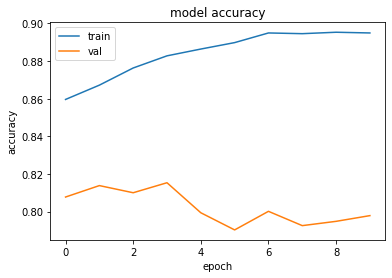

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

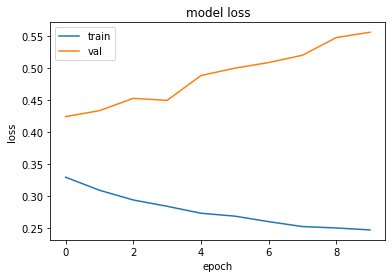

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#2. Training CNN-1D classifier on Bag of Words features.

X_train_bow = X_train_bow.reshape(X_train_bow.shape[0], X_train_bow.shape[1])

input = Input(batch_shape=(None, tf_len, 1))
drop20 = SpatialDropout1D(0.3)(input)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(drop20)
drop21 = Dropout(0.5)(conv2)
conv22 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop21)
drop22 = Dropout(0.5)(conv22)
pool2 = MaxPooling1D(pool_size=2)(drop22)
flat2 = Flatten()(pool2)
out = Dense(1, activation='sigmoid')(flat2)
model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000, 1)]         0         
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 5000, 1)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 4996, 128)         768       
                                                                 
 dropout_2 (Dropout)         (None, 4996, 128)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 4992, 64)          41024     
                                                                 
 dropout_3 (Dropout)         (None, 4992, 64)          0         
                                                           

In [ ]:
history = model.fit(x= X_train_bow,y=y_train,validation_data=(X_test_bow,y_test),shuffle=True,epochs=10,workers=2,use_multiprocessing=True)

Epoch 1/10
165/165 [==============================] - 20s 113ms/step - loss: 0.5792 - accuracy: 0.7369 - val_loss: 0.5972 - val_accuracy: 0.7325
Epoch 2/10
165/165 [==============================] - 18s 109ms/step - loss: 0.5302 - accuracy: 0.7614 - val_loss: 0.6547 - val_accuracy: 0.7196
Epoch 3/10
165/165 [==============================] - 17s 103ms/step - loss: 0.4860 - accuracy: 0.7806 - val_loss: 0.7350 - val_accuracy: 0.6907
Epoch 4/10
165/165 [==============================] - 17s 101ms/step - loss: 0.4572 - accuracy: 0.7990 - val_loss: 0.7983 - val_accuracy: 0.7067
Epoch 5/10
165/165 [==============================] - 17s 101ms/step - loss: 0.4372 - accuracy: 0.8070 - val_loss: 0.8846 - val_accuracy: 0.6915
Epoch 6/10
165/165 [==============================] - 17s 102ms/step - loss: 0.4249 - accuracy: 0.8131 - val_loss: 1.0006 - val_accuracy: 0.6839
Epoch 7/10
165/165 [==============================] - 17s 103ms/step - loss: 0.4108 - accuracy: 0.8209 - val_loss: 1.0059 - val_ac

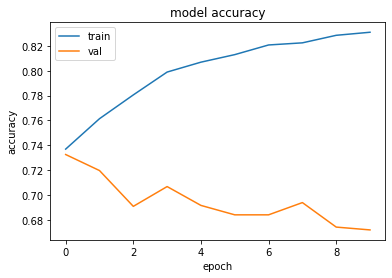

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

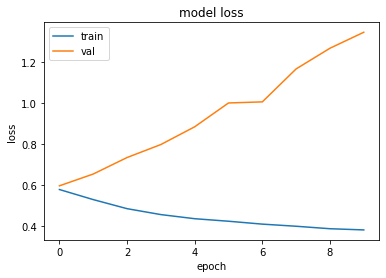

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#3. Training CNN-1D classifier on fast-text Features.

max_words = 16874
MAX_SEQUENCE_LENGTH=70
text_input_layer = Input(shape=(70,) ,dtype='int32')
embedding_layer = Embedding(max_words, 300, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)(text_input_layer)
text_layer = Conv1D(256, 3, activation='relu')(embedding_layer)
text_layer = Dropout(0.3)(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = Dropout(0.3)(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = Conv1D(256, 3, activation='relu')(text_layer)
text_layer = Dropout(0.3)(text_layer)
text_layer = MaxPooling1D(3)(text_layer)
text_layer = GlobalMaxPooling1D()(text_layer)
text_layer = Dense(256, activation='relu')(text_layer)
output_layer = Dense(1, activation='sigmoid')(text_layer)
model = Model(text_input_layer, output_layer)
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 70)]              0         
                                                                 
 embedding_26 (Embedding)    (None, 70, 300)           5062200   
                                                                 
 conv1d_93 (Conv1D)          (None, 68, 256)           230656    
                                                                 
 dropout_51 (Dropout)        (None, 68, 256)           0         
                                                                 
 max_pooling1d_89 (MaxPoolin  (None, 22, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_94 (Conv1D)          (None, 20, 256)           196864    
                                                          

In [ ]:
history=model.fit(train_seq_x, y_train,validation_data= (test_seq_x,y_test), epochs=10, shuffle=True,workers=2,use_multiprocessing=True)

Epoch 1/10
165/165 [==============================] - 2s 9ms/step - loss: 0.2930 - acc: 0.8613 - val_loss: 1.8255 - val_acc: 0.7166
Epoch 2/10
165/165 [==============================] - 1s 9ms/step - loss: 0.2913 - acc: 0.8625 - val_loss: 2.3229 - val_acc: 0.7166
Epoch 3/10
165/165 [==============================] - 2s 9ms/step - loss: 0.2927 - acc: 0.8619 - val_loss: 2.1133 - val_acc: 0.7143
Epoch 4/10
165/165 [==============================] - 1s 9ms/step - loss: 0.2955 - acc: 0.8617 - val_loss: 1.6342 - val_acc: 0.7120
Epoch 5/10
165/165 [==============================] - 1s 9ms/step - loss: 0.2925 - acc: 0.8621 - val_loss: 1.7671 - val_acc: 0.7052
Epoch 6/10
165/165 [==============================] - 1s 9ms/step - loss: 0.2994 - acc: 0.8609 - val_loss: 1.4708 - val_acc: 0.7318
Epoch 7/10
165/165 [==============================] - 1s 9ms/step - loss: 0.3002 - acc: 0.8602 - val_loss: 1.5214 - val_acc: 0.7014
Epoch 8/10
165/165 [==============================] - 2s 13ms/step - loss: 0

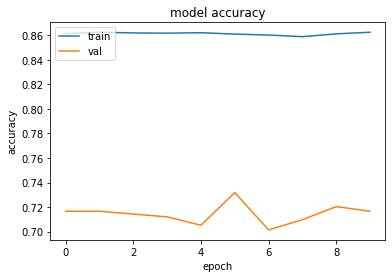

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

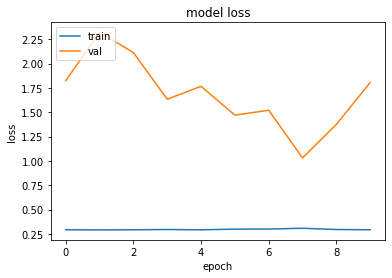

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#model.save_weights('Model_trained')


* Training LSTM Model on Extracted Embeddings.

In [ ]:
# Training CNN-1D classifier on TF-IDF Features.
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1])

input = Input(batch_shape=(None, tf_len, 1))
out1 = LSTM(units=16,return_sequences = True)(input)
out2 = LSTM(units=4, return_sequences = True)(out1)
out = LSTM(units=1, return_sequences = True)(out2)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 lstm_24 (LSTM)              (None, 5000, 16)          1152      
                                                                 
 lstm_25 (LSTM)              (None, 5000, 4)           336       
                                                                 
 lstm_26 (LSTM)              (None, 5000, 1)           24        
                                                                 
Total params: 1,512
Trainable params: 1,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x= X_train_tfidf,y=y_train,validation_data=(X_test_tfidf,y_test),shuffle=True,epochs=10,workers=2,use_multiprocessing=True,batch_size=1024)

Epoch 1/10


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


21/21 [==============================] - 158s 600ms/step - loss: 1.1395 - accuracy: 0.7371 - val_loss: 0.8343 - val_accuracy: 0.7280
Epoch 2/10
21/21 [==============================] - 11s 546ms/step - loss: 0.6878 - accuracy: 0.7371 - val_loss: 0.6202 - val_accuracy: 0.7280
Epoch 3/10
21/21 [==============================] - 13s 625ms/step - loss: 0.5922 - accuracy: 0.7371 - val_loss: 0.5880 - val_accuracy: 0.7280
Epoch 4/10
21/21 [==============================] - 12s 551ms/step - loss: 0.5787 - accuracy: 0.7371 - val_loss: 0.5879 - val_accuracy: 0.7280
Epoch 5/10
21/21 [==============================] - 13s 606ms/step - loss: 0.5781 - accuracy: 0.7371 - val_loss: 0.5871 - val_accuracy: 0.7280
Epoch 6/10
21/21 [==============================] - 11s 548ms/step - loss: 0.5780 - accuracy: 0.7371 - val_loss: 0.5876 - val_accuracy: 0.7280
Epoch 7/10
21/21 [==============================] - 11s 546ms/step - loss: 0.5779 - accuracy: 0.7371 - val_loss: 0.5872 - val_accuracy: 0.7280
Epoch 8/1

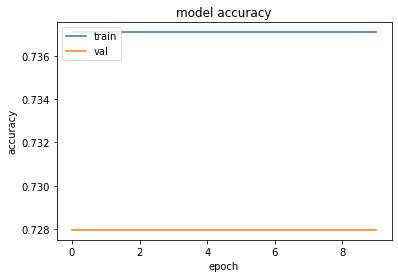

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

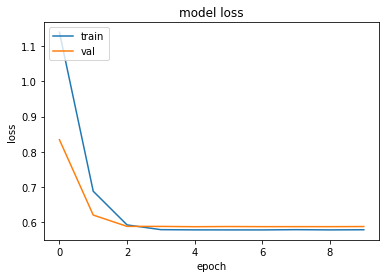

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Training LSTM classifier on Bow Features.
X_train_bow = X_train_bow.reshape(X_train_bow.shape[0], X_train_bow.shape[1])

from keras import Sequential
from keras.layers import LSTM

input = Input(batch_shape=(None, tf_len, 1))
out1 = LSTM(units=16,return_sequences = True)(input)
out2 = LSTM(units=4, return_sequences = True)(out1)
out = LSTM(units=1, return_sequences = True)(out2)

model = Model(input, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['acc'])
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 5000, 1)]         0         
                                                                 
 lstm_27 (LSTM)              (None, 5000, 16)          1152      
                                                                 
 lstm_28 (LSTM)              (None, 5000, 4)           336       
                                                                 
 lstm_29 (LSTM)              (None, 5000, 1)           24        
                                                                 
Total params: 1,512
Trainable params: 1,512
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x= X_train_bow,y=y_train,validation_data=(X_test_bow,y_test),shuffle=True,epochs=10,workers=2,use_multiprocessing=True,batch_size=64)

Epoch 1/10
83/83 [==============================] - 32s 381ms/step - loss: 0.7833 - acc: 0.7371 - val_loss: 0.5869 - val_acc: 0.7280
Epoch 2/10
83/83 [==============================] - 31s 369ms/step - loss: 0.5778 - acc: 0.7371 - val_loss: 0.5874 - val_acc: 0.7280
Epoch 3/10
83/83 [==============================] - 32s 383ms/step - loss: 0.5777 - acc: 0.7371 - val_loss: 0.5869 - val_acc: 0.7280
Epoch 4/10
83/83 [==============================] - 30s 368ms/step - loss: 0.5779 - acc: 0.7371 - val_loss: 0.5868 - val_acc: 0.7280
Epoch 5/10
83/83 [==============================] - 42s 505ms/step - loss: 0.5779 - acc: 0.7371 - val_loss: 0.5868 - val_acc: 0.7280
Epoch 6/10
83/83 [==============================] - 32s 388ms/step - loss: 0.5780 - acc: 0.7371 - val_loss: 0.5868 - val_acc: 0.7280
Epoch 7/10
83/83 [==============================] - 31s 369ms/step - loss: 0.5779 - acc: 0.7371 - val_loss: 0.5868 - val_acc: 0.7280
Epoch 8/10
83/83 [==============================] - 31s 369ms/step - 

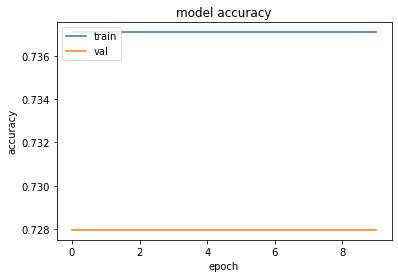

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

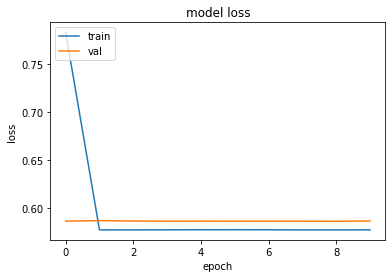

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Training LSTM classifier on FastText Embedding

X_train_bow = X_train_bow.reshape(X_train_bow.shape[0], X_train_bow.shape[1])

from keras import Sequential
from keras.layers import LSTM

max_words = 16874
MAX_SEQUENCE_LENGTH=70
text_input_layer = Input(shape=(70,) ,dtype='int32')
embedding_layer = Embedding(max_words, 300, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)(text_input_layer)
text_layer = LSTM(units=16,return_sequences = True)(embedding_layer)
text_layer = LSTM(units=4, return_sequences = True)(text_layer)
out = LSTM(units=1, return_sequences = True)(text_layer)

model = Model(text_input_layer, out)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['acc'])
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 70)]              0         
                                                                 
 embedding_28 (Embedding)    (None, 70, 300)           5062200   
                                                                 
 lstm_33 (LSTM)              (None, 70, 16)            20288     
                                                                 
 lstm_34 (LSTM)              (None, 70, 4)             336       
                                                                 
 lstm_35 (LSTM)              (None, 70, 1)             24        
                                                                 
Total params: 5,082,848
Trainable params: 5,082,848
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(train_seq_x, y_train,validation_data= (test_seq_x,y_test), epochs=10, shuffle=True,workers=2,use_multiprocessing=True)

Epoch 1/10
165/165 [==============================] - 86s 501ms/step - loss: 0.6097 - acc: 0.7371 - val_loss: 0.5933 - val_acc: 0.7280
Epoch 2/10
165/165 [==============================] - 2s 14ms/step - loss: 0.5817 - acc: 0.7371 - val_loss: 0.5892 - val_acc: 0.7280
Epoch 3/10
165/165 [==============================] - 2s 15ms/step - loss: 0.5790 - acc: 0.7371 - val_loss: 0.5873 - val_acc: 0.7280
Epoch 4/10
165/165 [==============================] - 2s 14ms/step - loss: 0.5779 - acc: 0.7371 - val_loss: 0.5871 - val_acc: 0.7280
Epoch 5/10
165/165 [==============================] - 2s 15ms/step - loss: 0.5772 - acc: 0.7371 - val_loss: 0.5867 - val_acc: 0.7280
Epoch 6/10
165/165 [==============================] - 2s 14ms/step - loss: 0.5770 - acc: 0.7371 - val_loss: 0.5861 - val_acc: 0.7280
Epoch 7/10
165/165 [==============================] - 2s 15ms/step - loss: 0.5767 - acc: 0.7371 - val_loss: 0.5863 - val_acc: 0.7280
Epoch 8/10
165/165 [==============================] - 2s 14ms/step 

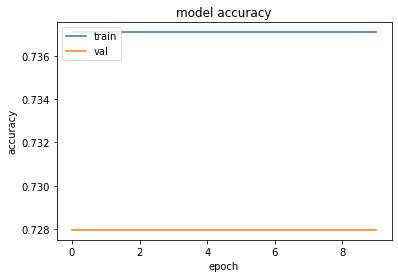

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

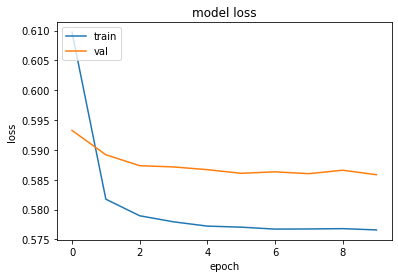

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Training a BERT Model on the dataset.

In [ ]:
#loading the preprocessing and encoder model
BERT_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
BERT_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#defining the model for classification
text_input = Input(shape=(), dtype=tf.string)
preprocessed_text = BERT_preprocess(text_input)
encoder_output = BERT_encoder(preprocessed_text)
#NN layers
out = Dropout(0.1)(encoder_output['pooled_output'])
out = Dense(1,activation='sigmoid')(out)

model = Model(inputs=[text_input], outputs=[out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_2[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)



In [ ]:
history= model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, workers=2,use_multiprocessing=True,batch_size=64)

Epoch 1/10
83/83 [==============================] - 187s 2s/step - loss: 0.5732 - accuracy: 0.7293 - precision: 0.2609 - recall: 0.0086 - val_loss: 0.5411 - val_accuracy: 0.7416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
83/83 [==============================] - 147s 2s/step - loss: 0.5430 - accuracy: 0.7363 - precision: 0.5843 - recall: 0.0371 - val_loss: 0.5013 - val_accuracy: 0.7432 - val_precision: 1.0000 - val_recall: 0.0029
Epoch 3/10
83/83 [==============================] - 140s 2s/step - loss: 0.5141 - accuracy: 0.7416 - precision: 0.6720 - recall: 0.0599 - val_loss: 0.4819 - val_accuracy: 0.7576 - val_precision: 0.8333 - val_recall: 0.0737
Epoch 4/10
83/83 [==============================] - 140s 2s/step - loss: 0.5017 - accuracy: 0.7534 - precision: 0.7376 - recall: 0.1162 - val_loss: 0.4680 - val_accuracy: 0.7485 - val_precision: 0.9000 - val_recall: 0.0265
Epoch 5/10
83/83 [==============================] - 140s 2s/step - loss: 0.4855 - accuracy: 0.7625 -

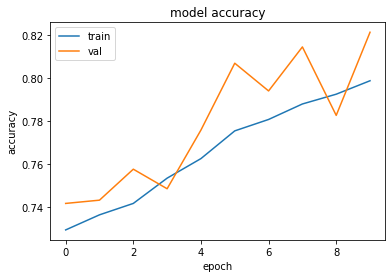

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

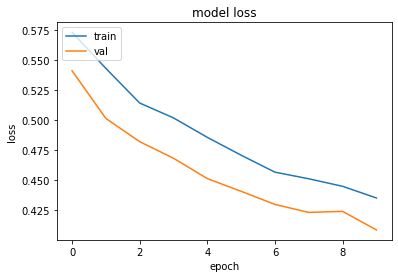

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()